# SMC & SMC'

In [1]:
# Import packages.
import copy
import matplotlib
from matplotlib import pyplot as plt
import msprime
import numpy as np
import pandas as pd
import smclib
# Print version numbers.
print('copy', matplotlib.__version__)
print('matplotlib', matplotlib.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)
print('pandas', pd.__version__)
# Intialize the matplolib styling.
plt.rcParams.update({
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'legend.frameon': False,
})

copy 3.6.3
matplotlib 3.6.3
msprime 1.2.0
numpy 1.23.5
pandas 1.5.3


## Number of Recombination Events

In [2]:
# Intialize an lisy of populuation recombination rate values.
R_rhos = np.array([0.1, 1, 10, 100, 1_000])
# Intialize a dictionary to store the receombination event results.
recomb_dicc = {
    'standard': np.zeros(R_rhos.size),
    'msp_smc': np.zeros(R_rhos.size),
    'djp_smc': np.zeros(R_rhos.size),
    'msp_smc_prime': np.zeros(R_rhos.size),
    'djp_smc_prime': np.zeros(R_rhos.size),
}
# For every population recombination rate.
for i, rho in enumerate(R_rhos):
    # Assuming Ne = 1, compute r.
    r = rho / 4
    # For 1000 replicate simulations.
    for _ in range(1000):
        # Simulate tree-sequences.
        ts_standard = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_msp_smc = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            model='smc',
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_msp_smc_prime = msprime.sim_ancestry(
            samples=[msprime.SampleSet(2, ploidy=1)],
            population_size=1,
            ploidy=2,
            recombination_rate=r,
            sequence_length=1,
            model='smc_prime',
            record_full_arg=True,
            discrete_genome=False,
        )
        ts_djp_smc = smclib.sim_smc(k=2, Ne=1, rho=rho, ploidy=2)
        ts_djp_smc_prime = smclib.sim_smc_prime(k=2, Ne=1, rho=rho, ploidy=2)
        # Update the dictionary.
        recomb_dicc['standard'][i] += smclib.R_g_arg(ts_standard)
        recomb_dicc['msp_smc'][i] += smclib.R_g_arg(ts_msp_smc)
        recomb_dicc['djp_smc'][i] += smclib.R_arg_dicc(ts_djp_smc)
        recomb_dicc['msp_smc_prime'][i] += smclib.R_g_arg(ts_msp_smc_prime)
        recomb_dicc['djp_smc_prime'][i] += smclib.R_arg_dicc(ts_djp_smc_prime)

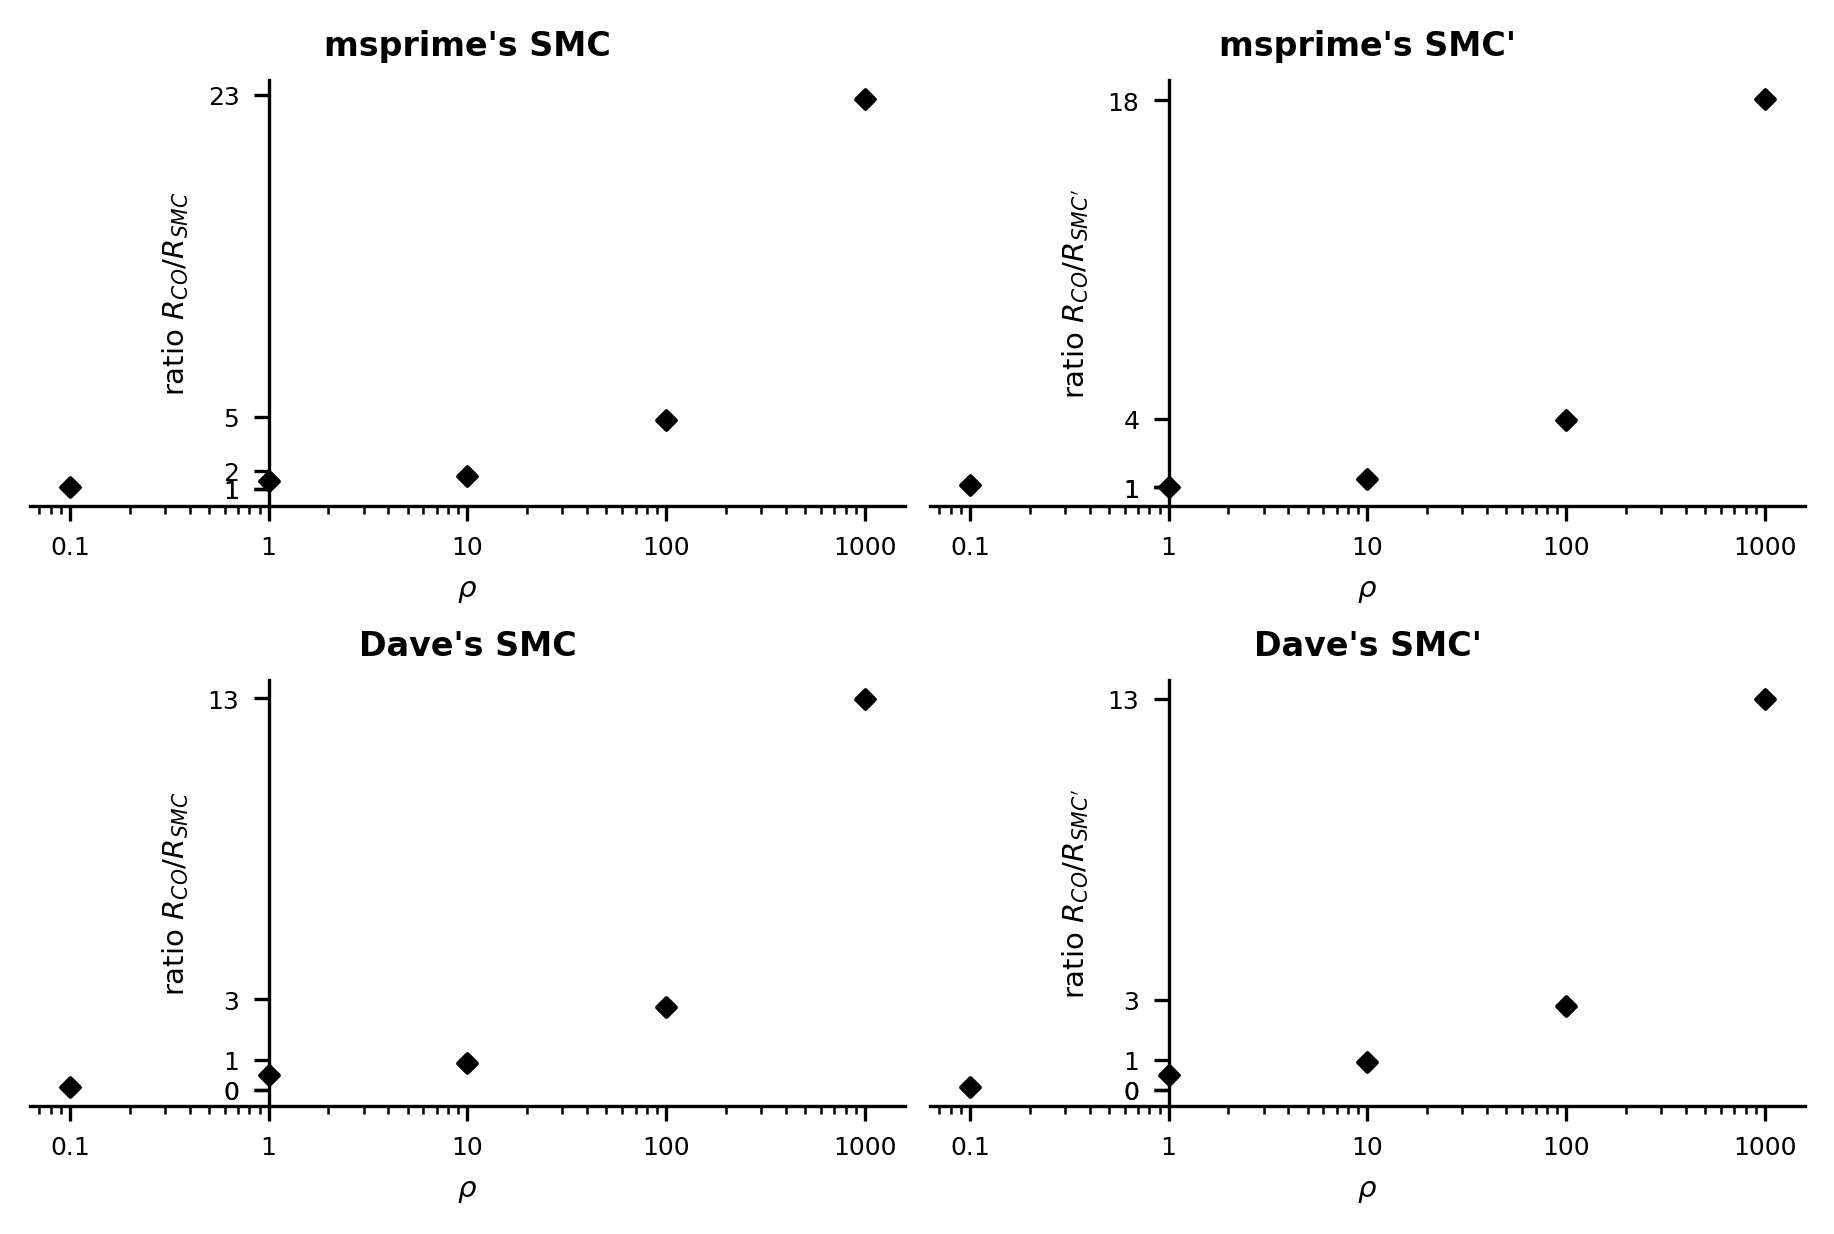

In [5]:
# Intialize figures and axes.
fig, axes = plt.subplots(
     2, 2, figsize=(6, 4),
    sharex=False, sharey=False, dpi=300,
)
# Intialize a dictionary for plotting.
plot_dicc = {
    'msp_smc': {'title': 'msprime\'s SMC', 'y_lab': r'ratio $R_{CO} / R_{SMC}$'},
    'msp_smc_prime': {'title': 'msprime\'s SMC\'', 'y_lab': r'''ratio $R_{CO} / R_{SMC'}$'''},
    'djp_smc': {'title': 'Dave\'s SMC', 'y_lab': r'ratio $R_{CO} / R_{SMC}$'},
    'djp_smc_prime': {'title': 'Dave\'s SMC\'', 'y_lab': r'''ratio $R_{CO} / R_{SMC'}$'''},
}
# Intialize axes list.
ax_list = [
    (0, 0), (0, 1),
    (1, 0), (1, 1),
]
# Intialize the mean number of crossovers for the standard coalescent.
standard_mean_co = recomb_dicc['standard'] / 1_000
# For every key.
for i, key in enumerate(plot_dicc):
    # Unpack the row and column indicies.
    row, col = ax_list[i]
    # Compute the R ratio.
    R_ratio = standard_mean_co / (recomb_dicc[key] / 1_000)
    # Plot the the results.
    axes[row, col].scatter(
        R_rhos, R_ratio, color='black',
        marker='D', s=10,
    )
    # Set the subplot title.
    axes[row, col].set_title(plot_dicc[key]['title'], fontweight='bold', size=8)
    # Set the axes labels.
    axes[row, col].set_xlabel(r'$\rho$', size=7)
    axes[row, col].set_ylabel(plot_dicc[key]['y_lab'], size=7)
    # Move the left spine (y-axis bar) to x = 1.
    axes[row, col].spines['left'].set_position(('data', 1))
    # Set the x-axis scale.
    axes[row, col].set_xscale('log')
    # Set the y-axis ticks and tick labels.
    axes[row, col].set_yticks(np.round(R_ratio))
    axes[row, col].set_yticklabels([str(round(ratio)) for ratio in R_ratio], size=6)
    # Set the axes scale, ticks, and tick labels.
    axes[row, col].set_xticks(R_rhos)
    axes[row, col].set_xticklabels([str(int(rho)) if rho.is_integer() else str(rho) for rho in R_rhos], size=6)
# Export the plot.
plt.savefig(
    './R_ratio_v03.png', format='png',
    facecolor='white', bbox_inches='tight', dpi=500,
)
# Show the plot.
plt.show()

In [6]:
# Intialize a data frame dictionary.
df_dicc = {}
# Intialize a list for column names.
col_names = [
    'msprime\'s Standard Coalescent $\hat{R_{CO}}$',
    r'''msprime's $\hat{R_{SMC}}$''', r'''msprime's $\hat{R_{SMC'}}$''',
    r'''Dave's $\hat{R_{SMC}}$''', r'''Dave's $\hat{R_{SMC'}}$''',
]
# For every key.
for i, key in enumerate(['standard', 'msp_smc', 'msp_smc_prime', 'djp_smc', 'djp_smc_prime']):
    # Compute the mean R.
    R_mean = (recomb_dicc[key] / 1_000)
    # Update the dictionary.
    df_dicc[col_names[i]] = np.round(R_mean, 3)
# Convert the dictionary to a data frame.
R_mean_df = pd.DataFrame(
    data=df_dicc,
    index=[r'$\rho =$ '+str(int(rho)) if rho.is_integer() else r'$\rho =$ '+str(rho) for rho in R_rhos],
)
# Export for good measures.
R_mean_df.to_csv('./R_mean_v03.csv', index=False)

In [7]:
# Show the mean R results.
R_mean_df

,msprime's Standard Coalescent $\hat{R_{CO}}$,msprime's $\hat{R_{SMC}}$,msprime's $\hat{R_{SMC'}}$,Dave's $\hat{R_{SMC}}$,Dave's $\hat{R_{SMC'}}$
$\rho =$ 0.1,0.115,0.105,0.105,1.209,1.203
$\rho =$ 1,1.422,0.988,1.395,2.971,2.903
$\rho =$ 10,19.121,11.107,14.268,21.333,20.686
$\rho =$ 100,556.118,115.020,140.813,201.767,200.371
$\rho =$ 1000,25941.796,1140.943,1437.477,2000.763,1997.564


## i$th$ Tree Height

In [2]:
# Define a list of tree indicies.
tree_idx = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -1])
# Intialize an lisy of populuation recombination rate values.
ith_rhos = np.array([1, 100])
# Intialize sample sizes.
ns = np.array([2, 20])
# Intialize a dictionary to store the receombination event results.
height_dicc = {
    'standard': {},
    'msp_smc': {},
    'djp_smc': {},
    'msp_smc_prime': {},
    'djp_smc_prime': {},
}
# For every sample size.
for n in ns:
    # Intialize subdictionaries.
    for key in height_dicc:
        height_dicc[key][n] = {}
    # For every population recombination rate.
    for rho in ith_rhos:
        # Intialize subdictionaries.
        for key in height_dicc:
            height_dicc[key][n][rho] = {}
        # Assuming Ne = 1, compute r.
        r = rho / 4
        # For every tree index.
        for idx in tree_idx:
            # Intialize subdictionaries.
            for key in height_dicc:
                height_dicc[key][n][rho][idx] = []
            # For 1000 replicate simulations.
            for _ in range(1000):
                # Simulate tree-sequences.
                ts_standard = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    discrete_genome=False,
                )
                ts_msp_smc = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    model='smc',
                    discrete_genome=False,
                )
                ts_msp_smc_prime = msprime.sim_ancestry(
                    samples=[msprime.SampleSet(n, ploidy=1)],
                    population_size=1,
                    ploidy=2,
                    recombination_rate=r,
                    sequence_length=1,
                    model='smc_prime',
                    discrete_genome=False,
                )
                ts_djp_smc = smclib.sim_smc(k=n, Ne=1, rho=rho, ploidy=2)
                ts_djp_smc_prime= smclib.sim_smc_prime(k=n, Ne=1, rho=rho, ploidy=2)
                # Update the dictionary.
                height_dicc['standard'][n][rho][idx].append(smclib.ith_tmrca_ts(ts=ts_standard, ith_tree=idx))
                height_dicc['msp_smc'][n][rho][idx].append(smclib.ith_tmrca_ts(ts=ts_msp_smc, ith_tree=idx))
                height_dicc['djp_smc'][n][rho][idx].append(smclib.ith_tmrca_ts_dicc(ts_dicc=ts_djp_smc, ith_tree=idx))
                height_dicc['msp_smc_prime'][n][rho][idx].append(smclib.ith_tmrca_ts(ts=ts_msp_smc_prime, ith_tree=idx))
                height_dicc['djp_smc_prime'][n][rho][idx].append(smclib.ith_tmrca_ts_dicc(ts_dicc=ts_djp_smc_prime, ith_tree=idx))

KeyError: 37

In [ ]:
# Intialize a dataframe dictionary.
df_dicc = {
    r'Sampled Lineages $(n)$': [],
    r'Population Recombination Rate $(\rho)$': [],
    r'$i$th Tree': [],
    'msprime Standard Coalescent': [],
    'msprime\'s SMC': [],
    'msprime\'s SMC\'': [],
    'Dave\'s SMC': [],
    'Dave\'s SMC\'': [],
}
# For every sample size.
for n in ns:
    # For every population recombination rate.
    for rho in ith_rhos:
        # For every tree index.
        for idx in tree_idx:
            # If the ith tree is not the last tree index.
            if idx != -1:
                # Add one to account for 0-indexing.
                ith = int(idx + 1)
            # Else.
            else:
                # Denote that this is the last tree.
                ith = 'last tree'
            # Update the dictionary with the simulation paramters and mean tmrca.
            df_dicc[r'Sampled Lineages $(n)$'].append(n)
            df_dicc[r'Population Recombination Rate $(\rho)$'].append(rho)
            df_dicc[r'$i$th Tree'].append(ith)
            df_dicc['msprime Standard Coalescent'].append(np.nanmean(np.array(height_dicc['standard'][n][rho][idx])))
            df_dicc['msprime\'s SMC'].append(np.nanmean(np.array(height_dicc['msp_smc'][n][rho][idx])))
            df_dicc['msprime\'s SMC\''].append(np.nanmean(np.array(height_dicc['msp_smc_prime'][n][rho][idx])))
            df_dicc['Dave\'s SMC'].append(np.nanmean(np.array(height_dicc['djp_smc'][n][rho][idx])))
            df_dicc['Dave\'s SMC\''].append(np.nanmean(np.array(height_dicc['djp_smc_prime'][n][rho][idx])))
# Convert the dictionary to a data frame.
height_df = pd.DataFrame(data=df_dicc)
# Export for good measures.
height_df.to_csv('./tree_height_v01.csv', index=False)

## Code in `smclib.py` for Debugging

In [2]:
# Intialize a node class.
class Node:
    
    # Intialize the node.
    def __init__(self, node_id, age, node_type, parent=None, l_child=None, r_child=None):
        """
        Node Types
            - 0: leaf node
            - 1: coalescent event node
            - 2: visibile recombination
            - 3: hidden recombination
        """
        self.node_id = node_id
        self.age = age
        self.node_type = node_type
        self.parent = parent
        self.l_child = l_child
        self.r_child = r_child
        self.parent_dist = None
        self.l_child_dist = None
        self.r_child_dist = None
        
    # Define a deep copy method.
    def __deepcopy__(self, memo):
        """
        Return a deepy copy of an isntance of the Node class.
        """
        # Avoid infinite loops
        if id(self) in memo:
            return memo[id(self)]
        # Create a shallow copy of the current node
        copied_node = copy.copy(self)
        memo[id(self)] = copied_node
        # Deep copy children and parent
        copied_node.parent = copy.deepcopy(self.parent, memo)
        copied_node.l_child = copy.deepcopy(self.l_child, memo)
        copied_node.r_child = copy.deepcopy(self.r_child, memo)
        return copied_node
    
    # Define a method to check if a node is a leaf.
    def is_leaf(self):
        """
        True if the node is a leaf, False otherwise.
        """
        return self.node_type == 0
    
    # Define a method to compute the distance to the children.
    def dist_to_children(self):
        """
        Compute the distance from the current node to its children.
        """
        if self.l_child is not None:
            self.l_child_dist = self.age - self.l_child.age
        if self.r_child is not None:
            self.r_child_dist = self.age - self.r_child.age
    
    # Define a method to compute the distance to the parent node.
    def dist_to_parent(self):
        """
        Compute the distance from the current node to its parent.
        """
        if self.parent is not None:
            self.parent_dist = self.parent.age - self.age
            
    # Define a function to initialize distance to parent and children nodes.
    def init_dists(self):
        """
        Intialize the distances to the parent and children nodes.
        """
        self.dist_to_parent()
        self.dist_to_children()

    
# Intialize a tree class.
class Tree:
    
    # Intialize the tree.
    def __init__(self, left=0.0, right=1.0):
        self.left = left
        self.right = right
        self.root = None
        self.length = None
        self.next_node_id = None
        self.next_rec_id = -1
        self.nodes = {}
        self.edges = {}
        self.upper_bounds = None
        self.recomb_node = None
        self.recoal_node = None
        
    def __deepcopy__(self, memo):
        """
        Return a deepy copy of an isntance of the Tree class.
        """
        # Avoid infinite loops.
        if id(self) in memo:
            return memo[id(self)]
        # Create a shallow copy of the tree.
        copied_tree = copy.copy(self)
        memo[id(self)] = copied_tree
        # Deep copy nodes and edges.
        copied_tree.nodes = copy.deepcopy(self.nodes, memo)
        copied_tree.edges = copy.deepcopy(self.edges, memo)
        return copied_tree
        
    # Define a method to add a node to the tree.
    def add_node(self, node):
        """
        Add a new node to the tree.
        """
        self.nodes[node.node_id] = node
        
    # Define a method to remove a node from the tree.
    def rmv_node(self, node):
        """
        Remove a new node to the tree.
        """
        del self.nodes[node.node_id]
    
    # Define a method to intialize node distances.
    def init_branch_lengths(self):
        """
        Intialize all the branch lengths for the current tree.
        """    
        # For every node.
        for node_id in self.nodes:
            # Intialize branch lengths.
            self.nodes[node_id].init_dists()
        
    # Define a method to intialize the edges on a tree.
    def init_edges(self):
        """
        Intialize all the edges on the current tree.
        """
        # Intialize variables.
        i = 0
        Lx = 0
        upper_bounds = []
        # For every node.
        for node in self.nodes:
            # If the node is not a leaf.
            if not self.nodes[node].is_leaf():
                # Record the interval's upper bound.
                upper_bounds.append(self.nodes[node].age)
                # Intialize the edge for parent -> left child.
                self.edges[i] = {}
                self.edges[i]['parent'] = self.nodes[node].node_id
                self.edges[i]['child'] = self.nodes[node].l_child.node_id
                self.edges[i]['upper'] = self.nodes[node].age
                self.edges[i]['lower'] = self.nodes[node].l_child.age
                self.edges[i]['length'] = self.nodes[node].l_child_dist
                i += 1
                Lx += self.nodes[node].l_child_dist
                # Intialize the edge for parent -> right child.
                self.edges[i] = {}
                self.edges[i]['parent'] = self.nodes[node].node_id
                self.edges[i]['child'] = self.nodes[node].r_child.node_id
                self.edges[i]['upper'] = self.nodes[node].age
                self.edges[i]['lower'] = self.nodes[node].r_child.age
                self.edges[i]['length'] = self.nodes[node].r_child_dist
                i += 1
                Lx += self.nodes[node].r_child_dist
        # Set the tree properties.
        self.upper_bounds = sorted(upper_bounds)
        self.length = Lx
                
    # Define a method to find the root node
    def find_root(self):
        """
        Determine the root node on the current tree.
        """
        root_node = max(self.nodes, key=lambda k: self.nodes[k].age)
        self.root = root_node
        
    # Define a method to replace an existing node's child with a new child.
    def replace_child(self, node_id, old_child, new_child):
        """
        Replace a node's existing child node.
        """
        # If the left child is the child we are replacing.
        if self.nodes[node_id].l_child.node_id == old_child.node_id:
            # Replace the left child with the new child node.
            self.nodes[node_id].l_child = new_child
        # If the right child is the child we are replacing.
        if self.nodes[node_id].r_child.node_id == old_child.node_id:
            # Replace the right child with the new child node.
            self.nodes[node_id].r_child = new_child
        
    # Define a method to replace an exiting node on the tree with a new node.
    def replace_node(self, old_node, new_node):
        """
        Remove an old node and add a new node.
        """
        # Remove the old node from the tree.
        self.rmv_node(old_node)
        # Add the new node to the tree.
        self.add_node(new_node)
    
    # Define a function to set the next node id.
    def init_next_node_id(self):
        """
        Set the next node id.
        """
        last_coal = self.recoal_node
        max_node = max(self.nodes)
        if last_coal is not None:
            self.next_node_id = max([last_coal.node_id, max_node]) + 1
        else:
            self.next_node_id = max_node + 1

In [3]:
# Define a function to intialize T_{0}.
def init_T0(k, Ne, ploidy, seed=None):
    """
    Returns a tree object and the tskit table of the first tree.
    
    k      -- Number of chromosomes to simulate.
    Ne     -- Effective population size.
    ploidy -- Haploid or diploid coalescent units.
    seed   -- Random seed for reporducibility.
    """
    # Simulate a tree under the standard coalescent.
    ts = msprime.sim_ancestry(
        samples=[msprime.SampleSet(k, ploidy=1)],
        population_size=Ne,
        ploidy=ploidy,
        random_seed=seed,
        discrete_genome=False,
    )
    # Make a copy of the tree-seq tables for editting.
    ts_tables = ts.dump_tables()
    
    print(ts.draw_text())
    
    return ts_tables

# Define a function to determine the distance to the next recombination event.
def draw_y(rho, Lx, ploidy):
    """
    Returns the distance to the next recombination event.
    
    rho    -- Population recombination rate.
    Lx     -- Total branch length of T_{x}.
    ploidy -- Haploid or diploid coalescent units.
    """
    # Draw y.
    y = np.random.exponential((1 / ((rho / ploidy) * Lx)))
    return y

# Define a function to determine the the lineage and age of the recombination event.
def draw_g(tree):
    """
    Returns the recombination event information for the current tree.
    
    tree -- An instance of the current tree.
    """
    # Compute the edge weights (ie edge_length/L(x)).
    edge_weights = [(tree.edges[key]['length'] / tree.length) for key in tree.edges.keys()]
    # Determine which edge will have the recombinatin event.
    rec_edge_key = np.random.choice(list(tree.edges.keys()), p=edge_weights)
    # Determine the age of the recombination event.
    g = np.random.uniform(tree.edges[rec_edge_key]['lower'], tree.edges[rec_edge_key]['upper'])
    return rec_edge_key, g

# Define a function to determine the lineage and age of the next coalescent event for the smc' model.
def draw_coal_smc_prime(tree, g, Ne, ploidy):
    """
    Returns the edge and coalescent information for the next tree.
    
    tree   -- An instance of the current tree
    g      -- Age of the recombination event on the current tree.
    Ne     -- Effective population size.
    ploidy -- Haploid or diploid coalescent units.
    """
    # Intialize the lower bound of the first interval.
    c_lower_bound = 0
    # Intialize the key of the edge where the coalescent event will occur.
    coal_edge_key = None
    # For every possible coalescent interval.
    for i, c_upper_bound in enumerate(tree.upper_bounds):
        # Determine if the recombination event occurs below the upper bound of the current interval.
        if c_upper_bound > g:
            # Determine the avaiable lineages in this interval.
            available_lineages = [
                key for key in tree.edges.keys() if\
                ((tree.edges[key]['upper'] >= c_upper_bound) & (tree.edges[key]['lower'] <= c_lower_bound))
            ] ### YOU CAN ADD THE CONDITION (key != rec_edge_key) FOR SMC ###
            # Determine the time of the coalescent event.
            coal_time = g + np.random.exponential(((Ne * ploidy) / len(available_lineages)))
            # If the the coalescent event occurs within the current time interval.
            if c_upper_bound > coal_time > c_lower_bound:
                # Determine which edge the coalescent event occurs on.
                coal_edge_key = np.random.choice(available_lineages)
                break
            # Else, re-intialize the lower bound and move on to the next interval.
            else:
                c_lower_bound = c_upper_bound
        # Else, re-intialize the lower bound and move on to the next interval.
        else:
            c_lower_bound = c_upper_bound
    # If an edge was not found within the current tree's interval.
    if coal_edge_key == None:
        # Determine the new time of coalescences above the root.
        coal_time = tree.nodes[tree.root].age + np.random.exponential((Ne * ploidy))
    return coal_edge_key, coal_time

# Define a function to determine the lineage and age of the next coalescent event for the smc model.
def draw_coal_smc(tree, rec_edge_key, g, Ne, ploidy):
    """
    Returns the edge and coalescent information for the next tree.
    
    tree              -- An instance of the current tree
    rec_edge_key      -- Key of the edge with the recombination event in tree.edges.
    g                 -- Age of the recombination event on the current tree.
    Ne                -- Effective population size.
    ploidy            -- Haploid or diploid coalescent units.
    """
    # Intialize the lower bound of the first interval.
    c_lower_bound = 0
    # Intialize the key of the edge where the coalescent event will occur.
    coal_edge_key = None
    # For every possible coalescent interval.
    for i, c_upper_bound in enumerate(tree.upper_bounds):
        # Determine if the recombination event occurs below the upper bound of the current interval.
        if c_upper_bound > g:
            # Determine the avaiable lineages in this interval.
            available_lineages = [
                key for key in tree.edges.keys() if\
                ((tree.edges[key]['upper'] >= c_upper_bound)\
                & (tree.edges[key]['lower'] <= c_lower_bound)\
                & (key != rec_edge_key))
            ]
            # If there are avaiable lineages.
            if len(available_lineages) > 0:
                # Determine the time of the coalescent event.
                coal_time = g + np.random.exponential(((Ne * ploidy) / len(available_lineages)))
            # Else set the coalescent event to a variable that will fail.
            else:
                coal_time = -1
            # If the the coalescent event occurs within the current time interval.
            if c_upper_bound > coal_time > c_lower_bound:
                # Determine which edge the coalescent event occurs on.
                coal_edge_key = np.random.choice(available_lineages)
                break
            # Else, re-intialize the lower bound and move on to the next interval.
            else:
                c_lower_bound = c_upper_bound
        # Else, re-intialize the lower bound and move on to the next interval.
        else:
            c_lower_bound = c_upper_bound
    # If an edge was not found within the current tree's interval.
    if coal_edge_key == None:
        # Determine the new time of coalescences above the root.
        coal_time = tree.nodes[tree.root].age + np.random.exponential((Ne * ploidy))
    return coal_edge_key, coal_time

In [15]:
## (0) Intialize the inputs for the the SMC/SMC' algorithim. ###

k = 3
Ne = 1
rho = 5
ploidy = 2
seed = 42

## (1) Intialize the first tree, T(x)=T_{0}, at position x=0, and compute the total branch length L(x)=L_{0}. ##

# Intialize a tree-sequence dictionary.
ts_dicc = {}
# Intialize the first tree index.
tree_idx = 0
# Intialize the start position.
x = 0
# Simulate a tree (T_{0}) under the standard coalescent at point x=0.
ts_tables = init_T0(k=k, Ne=Ne, ploidy=ploidy, seed=seed)
# Intialize the current tree.
c_tree = Tree()
# For ever node.
for node_id, age in enumerate(ts_tables.nodes.time):
    # If the node is a leaf.
    if age == 0:
        # Intialize the node.
        node = Node(
            node_id=node_id, age=age, node_type=0,
            parent=None, l_child=None, r_child=None,
        )
        # Add the node to the tree.
        c_tree.add_node(node)
    # Else, the node is an ancestral node.
    else:
        # Intialize the node.
        node = Node(
            node_id=node_id, age=age, node_type=1,
            parent=None, l_child=None, r_child=None,
        )
        # Add the node to the tree.
        c_tree.add_node(node)
# For every parent node.
for parent in np.unique(ts_tables.edges.parent):
    # Find the children of the parent node.
    left_child, right_child = ts_tables.edges[ts_tables.edges.parent == parent].child
    # Update the parent node for the two children.
    c_tree.nodes[left_child].parent = c_tree.nodes[parent]
    c_tree.nodes[right_child].parent = c_tree.nodes[parent]
    # Update the children nodes for the parent.
    c_tree.nodes[parent].l_child = c_tree.nodes[left_child]
    c_tree.nodes[parent].r_child = c_tree.nodes[right_child]
# Intialize branch lengths.
c_tree.init_branch_lengths()
# Intialize the edges for the current tree.
c_tree.init_edges()
# Intialize the root node.
c_tree.find_root()
# Intialize the next node id.
c_tree.init_next_node_id()

## (2) Generate the distance, y=exp[(rho/2)L(x)], to the next recombination event. ##

# Compute the distance to the next recombination event (y).
y = draw_y(rho=rho, Lx=c_tree.length, ploidy=ploidy)

print(f'first interval: [{x}, {y})')

# While we are still within the sequence intervals.
while (x + y) < 1:
    # Intialize the new right position
    c_tree.right = (x + y)
    
## (3) Determine the location (ie what edge), and the age of the recombination event (g). ##

    # Determine g and its location on the current tree.
    rec_edge_key, g = draw_g(tree=c_tree)
        
    print(f'recombination event age: {g}')
    print('recombination edge:')
    print(c_tree.edges[rec_edge_key])
    
## (4) Overlay the recombination event at time g and allow the branch below g to coalesce elsewhere on the tree. ##

    # Deteremine the location and time of the recombining coalescent event.
    coal_edge_key, coal_time = draw_coal_smc_prime(tree=c_tree, g=g, Ne=Ne, ploidy=ploidy)
    
    print(f're-coalesence age: {coal_time}')
    if coal_edge_key is None:
        print(f're-coalesence is above the root node (ie, node id: {c_tree.root})')
    else:
        print('re-coalesence edge:')
        print(c_tree.edges[coal_edge_key])
        
## (5) Prune the old branch above g and graft the new branch to construct the next tree at position x+y. ##
    
    ### HIDDEN RECOMBINATION SCENARIO ###
    # If the coalescent event is hidden (ie recombination and coalesence occur on the same branch).
    if rec_edge_key == coal_edge_key:
        
        print('hidden recombination event')
        
        # Intialize a recombination event node for the current tree.
        recomb_node = Node(
            node_id=c_tree.next_rec_id, age=g, node_type=3,
            parent=c_tree.nodes[c_tree.edges[rec_edge_key]['parent']],
            l_child=c_tree.nodes[c_tree.edges[rec_edge_key]['child']], r_child=None,
        )
        # Intialize the re-coalesence event node for the current tree.
        coal_node = Node(
            node_id=c_tree.next_node_id, age=coal_time, node_type=1,
            parent=c_tree.nodes[c_tree.edges[coal_edge_key]['parent']],
            l_child=c_tree.nodes[c_tree.edges[coal_edge_key]['child']], r_child=None,
        )
        # Move the the recombination event node counter back.
        c_tree.next_rec_id -= 1
        # Move the coalescent event node counter forward.
        c_tree.next_node_id += 1
        # Record the recombination event.
        c_tree.recomb_node = recomb_node
        # Record the re-coalesence event.
        c_tree.recoal_node = coal_node
        # Add the current tree to the tree-sequence dictionary.
        ts_dicc[tree_idx] = c_tree
        # Move the tree index forward.
        tree_idx += 1
        # Intialize the next tree by copying the current tree.
        n_tree = copy.deepcopy(c_tree)
        n_tree.left = (x + y)
        n_tree.right = 1.0
    # Else, the coalescent event is not hidden.
    else:
        ### Perform the SPR Algorithim ###
        # Intialize a recombination event node for the current tree.
        recomb_node = Node(
            node_id=c_tree.next_rec_id, age=g, node_type=2,
            parent=c_tree.nodes[c_tree.edges[rec_edge_key]['parent']],
            l_child=c_tree.nodes[c_tree.edges[rec_edge_key]['child']], r_child=None,
        )
        # Move the the recombination event node counter back.
        c_tree.next_rec_id -= 1
        # Record the recombination event.
        c_tree.recomb_node = recomb_node
        ## [0] Intialize nodes of interest. ##
        # Idenitfy the broken node (ie the parent node directly above g).
        broken_node = c_tree.nodes[c_tree.edges[rec_edge_key]['parent']].node_id
        # Identify the node to be inherited (ie the parent node directly below g).
        inherited_node = c_tree.nodes[c_tree.edges[rec_edge_key]['child']].node_id
        # Identify the root node.
        root_node = c_tree.root
        # Idenitfy the lonely node not inherited (ie the child node of the broken node not inherited).
        if c_tree.nodes[broken_node].l_child.node_id == inherited_node:
            lonely_node = c_tree.nodes[broken_node].r_child.node_id
        else:
            lonely_node = c_tree.nodes[broken_node].l_child.node_id
        # Identify the below node (ie the node directly below the re-coalescence event.)
        if coal_edge_key == None:
            # Intialize the below node as the root node.
            below_node = root_node
            # Intialize the next node id.
            next_id = c_tree.next_node_id
            # Intialize the re-coalesence event node for the current tree.
            coal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None, l_child=c_tree.nodes[below_node], r_child=None,
            )
            # Record the re-coalesence event.
            c_tree.recoal_node = coal_node
            # Add the current tree to the tree-sequence dictionary.
            ts_dicc[tree_idx] = c_tree
            # Move the tree index forward.
            tree_idx += 1
            # Intialize the next tree by copying the current tree.
            n_tree = copy.deepcopy(c_tree)
            n_tree.left = (x + y)
            n_tree.right = 1.0
        else:
            # Intialize the below node
            below_node = c_tree.nodes[c_tree.edges[coal_edge_key]['child']].node_id
            # Intialize the next node id.
            next_id = c_tree.next_node_id
            # Intialize the re-coalesence event node for the current tree.
            coal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=c_tree.nodes[c_tree.edges[coal_edge_key]['parent']],
                l_child=c_tree.nodes[below_node], r_child=None,
            )
            # Record the re-coalesence event.
            c_tree.recoal_node = coal_node
            # Add the current tree to the tree-sequence dictionary.
            ts_dicc[tree_idx] = c_tree
            # Move the tree index forward.
            tree_idx += 1
            # Intialize the next tree by copying the current tree.
            n_tree = copy.deepcopy(c_tree)
            n_tree.left = (x + y)
            n_tree.right = 1.0
            
        print(f'root node: {root_node}')
        print(f'broken node: {broken_node}')
        print(f'below node: {below_node}')
        print(f'lonely node {lonely_node}')
        print(f'inherited node: {inherited_node}')
            
        ## [1] The broken and below nodes are the root node. ##
        if (broken_node == root_node) & (below_node == root_node):
            
            print('spr scenario 1')
            
            # [1.1] Intialize the recoal node with the inherited node and lonely node as children. #
            recoal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None,
                l_child=n_tree.nodes[inherited_node], r_child=n_tree.nodes[lonely_node],
            )
            n_tree.nodes[inherited_node].parent = recoal_node
            n_tree.nodes[lonely_node].parent = recoal_node
            # [1.2] Replace the broken node with the recoal node on the new tree. #
            n_tree.replace_node(
                old_node=n_tree.nodes[broken_node],
                new_node=recoal_node,
            )
        ## [2] The broken node is the below node and not the root node. ##
        elif (broken_node == below_node) & (broken_node != root_node):
            
            print('spr scenario 2')
            
            # [2.1] Intialize the recoal node with the inherited node and lonely node as children. #
            recoal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None,
                l_child=n_tree.nodes[inherited_node], r_child=n_tree.nodes[lonely_node],
            )
            n_tree.nodes[inherited_node].parent = recoal_node
            n_tree.nodes[lonely_node].parent = recoal_node
            # [2.2] Set the parent of broken/below node as the parent of the recoal node. #
            recoal_node.parent = n_tree.nodes[broken_node].parent
            # [2.3] Replace the broken node with the recoal node on the new tree. #
            n_tree.replace_node(
                old_node=n_tree.nodes[broken_node],
                new_node=recoal_node,
            )
        ## [3] The broken node is the root node. ##
        elif (broken_node == root_node) & (below_node != root_node):
            # [3.1] Intialize the recoal node with the inherited node and below node as children. #
            recoal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None,
                l_child=n_tree.nodes[inherited_node], r_child=n_tree.nodes[below_node],
            )
            n_tree.nodes[inherited_node].parent = recoal_node
            n_tree.nodes[below_node].parent = recoal_node
            # [3.2A] The below node is the lonely node. #
            if below_node == lonely_node:
                
                print('spr scenario 3A')
                
                # [3.2A.1] Replace the broken node with the recoal node on the new tree. #
                n_tree.replace_node(
                    old_node=n_tree.nodes[broken_node],
                    new_node=recoal_node,
                )
            # [3.2B] The below node is not the lonely node. #
            else:
                
                print('spr scenario 3B')
                
                # [3.2B.1] Set the lonely node as the new root node. #
                n_tree.nodes[lonely_node].parent = None
                # [3.2B.2] Set the lonely node as parent of the recoal node. #
                recoal_node.parent = n_tree.nodes[lonely_node]
                # [3.2B.3] Replace the below node with the recoal node in the parent of the #
                # below node's children set. #
                n_tree.replace_child(
                    node_id=c_tree.edges[coal_edge_key]['parent'],
                    old_child=n_tree.nodes[below_node],
                    new_child=recoal_node,
                )
                # [3.2B.4] Replace the broken node with the recoal node on the new tree. #
                n_tree.replace_node(
                    old_node=n_tree.nodes[broken_node],
                    new_node=recoal_node,
                )
        ## [4] The below node is the root node. ##
        elif (below_node == root_node) & (broken_node != root_node):
            
            print('spr scenario 4')
            
            # [4.1] Intialize the recoal node with the inherited node and below node as children. #
            recoal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None,
                l_child=n_tree.nodes[inherited_node], r_child=n_tree.nodes[below_node],
            )
            n_tree.nodes[inherited_node].parent = recoal_node
            n_tree.nodes[below_node].parent = recoal_node
            # [4.2] Replace the broken node with the recoal node in the parent of the #
            # broken node's children set. #
            n_tree.replace_child(
                node_id=n_tree.nodes[broken_node].parent.node_id,
                old_child=n_tree.nodes[broken_node],
                new_child=n_tree.nodes[lonely_node],
            )
            # [4.3] Replace the broken node with the recoal node on the new tree. #
            n_tree.replace_node(
                old_node=n_tree.nodes[broken_node],
                new_node=recoal_node,
            )
        ## [5] The broken node, below node, and root node are all unique. ##
        else:
            # [5.1] Intialize the recoal node with the inherited node and below node as children. #
            recoal_node = Node(
                node_id=next_id, age=coal_time, node_type=1,
                parent=None,
                l_child=n_tree.nodes[inherited_node], r_child=n_tree.nodes[below_node],
            )
            n_tree.nodes[inherited_node].parent = recoal_node
            n_tree.nodes[below_node].parent = recoal_node
            # [5.2A] The below node is the lonely node. #
            if below_node == lonely_node:
                
                print('spr scenario 5A')
                
                # [5.2A.1] Set the parent of the broken node as parent of the recoal node. #
                recoal_node.parent = n_tree.nodes[broken_node].parent
                # [5.2A.2] Replace the broken node with the recoal node in the parent of the #
                # broken node's children set. #
                n_tree.replace_child(
                    node_id=n_tree.nodes[broken_node].parent.node_id,
                    old_child=n_tree.nodes[broken_node],
                    new_child=n_tree.nodes[lonely_node],
                )
                # [5.2A.3] Replace the broken node with the recoal node on the new tree. #
                n_tree.replace_node(
                    old_node=n_tree.nodes[broken_node],
                    new_node=recoal_node,
                )
            # [5.2B] The below node and the lonely node are unique. #
            else:
                
                print('spr scenario 5B')
                
                # [5.2B.1] Set the parent of the broken node as parent of the lonely node. #
                n_tree.nodes[lonely_node].parent = n_tree.nodes[broken_node].parent
                # [5.2B.2] Set the parent of the below node as parent of the lonely node. #
                recoal_node.parent = n_tree.nodes[c_tree.edges[coal_edge_key]['parent']]
                # [5.2B.3] Replace the below node with the recoal node in the parent of the #
                # below node's children set. #
                n_tree.replace_child(
                    node_id=c_tree.edges[coal_edge_key]['parent'],
                    old_child=n_tree.nodes[below_node],
                    new_child=recoal_node,
                )
                # [5.2B.4] Replace the broken node with the recoal node on the new tree. #
                n_tree.replace_node(
                    old_node=n_tree.nodes[broken_node],
                    new_node=recoal_node,
                )
    # Intialize branch lengths for the new tree.
    n_tree.init_branch_lengths()
    # Intialize the edges for the new tree.
    n_tree.init_edges()
    # Intialize the root node for the new tree
    n_tree.find_root()
    # Intialize the next node ids for the new tree.
    n_tree.init_next_node_id()
    # Set the new tree as the current tree.
    c_tree = n_tree
    
## (6) Reset the new interval x=x+y, intialize the new tree as the current tree T(x), and compute the compute the total branch length L(x). ##
    
    # Reset the new left interval (x).
    x = (x + y)
    # Compute the distance to the next recombination event (y).
    y = draw_y(rho=rho, Lx=c_tree.length, ploidy=ploidy)
    
    print(f'distance to the next brakepoint: {y}')
    print('--------------------------------------------------------------------------------')
    print('\n')
    print(f'next interval: [{x}, {x + y})')

# Remove the recombination an re-coalescence nodes from the last tree,
# that did not expirence recombination.
c_tree.recomb_node = None
c_tree.recoal_node = None

print(f'last interval: [{c_tree.left}, {c_tree.right})')

# Add the last tree to the tree-sequence.
ts_dicc[tree_idx] = c_tree

0.72┊   4   ┊
    ┊  ┏┻━┓ ┊
0.31┊  3  ┃ ┊
    ┊ ┏┻┓ ┃ ┊
0.00┊ 0 1 2 ┊
    0       1

first interval: [0, 0.14495605228729916)
recombination event age: 0.5508412896453817
recombination edge:
{'parent': 4, 'child': 2, 'upper': 0.7181423917434264, 'lower': 0.0, 'length': 0.7181423917434264}
re-coalesence age: 1.2146209653580413
re-coalesence is above the root node (ie, node id: 4)
root node: 4
broken node: 4
below node: 4
lonely node 3
inherited node: 2
spr scenario 1
distance to the next brakepoint: 0.24668956868336298
--------------------------------------------------------------------------------


next interval: [0.14495605228729916, 0.39164562097066213)
recombination event age: 0.159164396429703
recombination edge:
{'parent': 3, 'child': 0, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
re-coalesence age: 0.1638210558671687
re-coalesence edge:
{'parent': 3, 'child': 0, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
hidden recombinat

In [16]:
print(f'there are {len(ts_dicc)} trees in the tree-sequence')
print('\n')
for tree in ts_dicc:
    print(f'tree: {tree}')
    print(f'[left, right): [{ts_dicc[tree].left}, {ts_dicc[tree].right})')
    if (ts_dicc[tree].recomb_node is not None) & (ts_dicc[tree].recoal_node is not None):
        recomb_info = []
        recomb_info.append(ts_dicc[tree].recomb_node.node_id)
        recomb_info.append(ts_dicc[tree].recomb_node.age)
        recomb_info.append(ts_dicc[tree].recomb_node.parent.node_id)
        recomb_info.append(ts_dicc[tree].recomb_node.l_child.node_id)
        recoal_info = []
        recoal_info.append(ts_dicc[tree].recoal_node.node_id)
        recoal_info.append(ts_dicc[tree].recoal_node.age)
        if ts_dicc[tree].recoal_node.parent is not None:
            recoal_info.append(ts_dicc[tree].recoal_node.parent.node_id)
        else:
            recoal_info.append(ts_dicc[tree].root)
        recoal_info.append(ts_dicc[tree].recoal_node.l_child.node_id)
        print(f'recomb event id: {recomb_info[0]}, age: {recomb_info[1]}, parent: {recomb_info[2]}, child: {recomb_info[3]}')
        print(f'recoal event id: {recoal_info[0]}, age: {recoal_info[1]}, parent: {recoal_info[2]}, child: {recoal_info[3]}')
    for node in ts_dicc[tree].nodes:
        if ts_dicc[tree].nodes[node].is_leaf():
            print(f'leaf: {ts_dicc[tree].nodes[node].node_id}, parent: {ts_dicc[tree].nodes[node].parent.node_id}')
        else:
            print(f'{ts_dicc[tree].nodes[node].node_id}: ({ts_dicc[tree].nodes[node].l_child.node_id}, {ts_dicc[tree].nodes[node].r_child.node_id})')
    for edge in ts_dicc[tree].edges:
        print(ts_dicc[tree].edges[edge])
    print('\n')

there are 5 trees in the tree-sequence


tree: 0
[left, right): [0.0, 0.14495605228729916)
recomb event id: -1, age: 0.5508412896453817, parent: 4, child: 2
recoal event id: 5, age: 1.2146209653580413, parent: 4, child: 4
leaf: 0, parent: 3
leaf: 1, parent: 3
leaf: 2, parent: 4
3: (0, 1)
4: (2, 3)
{'parent': 3, 'child': 0, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
{'parent': 3, 'child': 1, 'upper': 0.3128453884812263, 'lower': 0.0, 'length': 0.3128453884812263}
{'parent': 4, 'child': 2, 'upper': 0.7181423917434264, 'lower': 0.0, 'length': 0.7181423917434264}
{'parent': 4, 'child': 3, 'upper': 0.7181423917434264, 'lower': 0.3128453884812263, 'length': 0.40529700326220014}


tree: 1
[left, right): [0.14495605228729916, 0.39164562097066213)
recomb event id: -2, age: 0.159164396429703, parent: 3, child: 0
recoal event id: 6, age: 0.1638210558671687, parent: 3, child: 0
leaf: 0, parent: 3
leaf: 1, parent: 3
leaf: 2, parent: 5
3: (0, 1)
5: (2, 3)
{'parent': 3, 